## This notebook loads the GPU model and can then generates predictions for sequences using the model 

## - Using this notebook, one can evaluate the performance on both the random data test data ( Fig. 1b ) and the native test data ( Fig. 1c) for the GPU model. We also generate predictions and reconstruct scatterplots for the other panels where the GPU model was used in the manuscript ( the genetic algorithm section (Fig. 1d) , the random mutational drift section (Fig. 2a-c), the SSWM section(Fig. 2e-f) )


### - The saved model weights for the GPU model can be found in the 'model' folder in this directory. So one can use the code in this notebook to generate predictions for any sequence they desire.

### - The last cell shows how you can use the GPU model to predict the expression for your own sequences

#### Important Note for the Reviewers and Readers : 
- Our test datasets in the manuscript (for example the ones used in Fig. 1b,c, Extended Data Fig. 2, Supplementary Fig. 4, etc. ) are not simply held-out subsets of the training datasets. They are separate test datasets generated as part of completely independent experiments with lower-complexity (~1000 fold lower sequence diversity) libraries than the large-scale training data generation experiments resulting in expression measurements with a low measurement-error. The test data used here can be found in the `../../../data/test_data/` folder relative to this notebook's current directory.

- Since the training data and the test data are collected in different experiments, the units of expression are on different unrelated scales (the units are arbitrary units local to experiments and not absolute comparable units across experiments) because of the nature of GPRA/Sort-seq experiments.


### General Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import tensorflow as tf
from sklearn.decomposition import PCA
import pickle
import time
import tensorflow as tf
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib
import multiprocessing as mp
import seaborn as sns



##Matplotlib rc params
# Font family : https://matplotlib.org/tutorials/introductory/customizing.html , http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/ , https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib , https://stackoverflow.com/questions/26106552/matplotlib-style-library-not-updating-when-mplstyle-files-added-deleted , https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html , http://www.jesshamrick.com/2016/04/13/reproducible-plots/ , 
#
from matplotlib import rcParams
rcParams.update(matplotlib.rcParamsDefault)
rcParams['pdf.fonttype'] = 42
sns.set(context = 'paper' , style='ticks' , 
        rc = {
            'figure.autolayout' : True,
            'axes.titlesize' : 8 ,
            'axes.titleweight' :'bold',
            
            'figure.titleweight' : 'bold' ,
            'figure.titlesize' : 8 ,
            
            'axes.labelsize' : 8 ,
            'axes.labelpad' : 2 ,
            'axes.labelweight' : 'bold' , 
            'axes.spines.top' : False,
            'axes.spines.right' : False,
            
            'xtick.labelsize' : 7 ,
            'ytick.labelsize' : 7 ,
            
            'legend.fontsize' : 7 ,
            'figure.figsize' : (3.5, 3.5/1.6 ) ,          
            
            'xtick.direction' : 'out' ,
            'ytick.direction' : 'out' ,
            
            'xtick.major.size' : 2 ,
            'ytick.major.size' : 2 ,
            
            'xtick.major.pad' : 2,
            'ytick.major.pad' : 2,
            
            #'lines.linewidth' : 1            
            
             } )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

### Import helper functions 

Code block below includes : 

- Helper functions for converting sequences to one hot code 
- A getPredictions function that can generate predictions for the model 

- We apologize that this code is not modular : this uses the old Tensorflow (sessions and graphs) and so it is much more convenient to inline it.



In [2]:
### Helper functions
def population_remove_flank(population) : 
    return_population = []
    for i in range(len(population)): 
        return_population= return_population + [(population[i][17:-13])]
    return return_population

def population_add_flank(population) : 
    left_flank = ''.join(['T','G','C','A','T','T','T','T','T','T','T','C','A','C','A','T','C'])
    right_flank = ''.join(['G','G','T','T','A','C','G','G','C','T','G','T','T'] )
    population = copy.deepcopy(population)
    for ind in range(len(population)) :
        if not population[ind]!=population[ind]:#math.isnan(population[ind]):       
            population[ind] =  left_flank+ ''.join(population[ind]) + right_flank
        else :
            print(ind)

    return population
#######





def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)



%matplotlib inline
import matplotlib.cm as cm
import pickle , csv ,  argparse , os ,random , multiprocessing , copy , scipy , multiprocessing
import tensorflow as tf, sys, numpy as np, h5py, pandas as pd
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn import preprocessing

from os.path import splitext,exists,dirname,join,basename


# Function to embed sequences and another one to get reverse complements , made for 6.874
def seq2feature(data,mapper,worddim):

    transformed = np.zeros([data.shape[0],1,len(data[0]),4] , dtype=np.bool )
    for i in range(data.shape[0]) :
        for j,k in enumerate(data[i]):
            #print j,k
            transformed[i,0,j] = mapper[k] 
            #print mapper[k]
    return transformed
    


def get_rc(A):
    A_r = np.flip(A,2)
    A = A_r
    A_onehot = np.array([1,0,0,0] ,  dtype=np.bool)
    C_onehot = np.array([0,1,0,0] ,  dtype=np.bool)
    G_onehot = np.array([0,0,1,0] ,  dtype=np.bool)
    T_onehot = np.array([0,0,0,1] ,  dtype=np.bool)
    N_onehot = np.array([0,0,0,0] ,  dtype=np.bool)

    for i in range(A.shape[0]) : 
        for j in range(A.shape[2]) : 
            if np.array_equal(A[i][0][j] , A_onehot) :
                A[i][0][j] = T_onehot
            elif np.array_equal(A[i][0][j] , C_onehot) :
                A[i][0][j] = G_onehot
            elif np.array_equal(A[i][0][j] , G_onehot) :
                A[i][0][j] = C_onehot
            elif np.array_equal(A[i][0][j] , T_onehot) :
                A[i][0][j] = A_onehot
            elif np.array_equal(A[i][0][j] , N_onehot) :
                A[i][0][j] = N_onehot

                
    return A






def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))


# Borrowed and modified from Effective Tensorflow: https://github.com/vahidk/EffectiveTensorflow#multi_gpu
def make_parallel(fn, num_gpus, **kwargs):
    in_splits = {}
    for k, v in kwargs.items():
        in_splits[k] = tf.split(v, num_gpus)

    out_split=[]
    for i in range(num_gpus):
        with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
            with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
                out_split.append(fn(**{k : v[i] for k, v in in_splits.items()}))

    out_splits=[]

    out_splits.append(tf.concat([x[0] for x in out_split], axis=0))
    out_splits.append(tf.stack([x[1] for x in out_split], axis=0))
    return out_splits






### This function allows us to generate outputs for any input sequence list
def getPredictions(sequences_raw , sess , graph, X, X_rc, Y, model_cost, model_output ):

    BASEORDER = list("ACGT")
    A_onehot = np.array([1,0,0,0] ,  dtype=np.bool)
    C_onehot = np.array([0,1,0,0] ,  dtype=np.bool)
    G_onehot = np.array([0,0,1,0] ,  dtype=np.bool)
    T_onehot = np.array([0,0,0,1] ,  dtype=np.bool)
    N_onehot = np.array([0,0,0,0] ,  dtype=np.bool)

    mapper = {'A':A_onehot,'C':C_onehot,'G':G_onehot,'T':T_onehot,'N':N_onehot}
    worddim = len(mapper['A'])
 
    


    if(np.ndim(sequences_raw)==1) : 
        if(len(sequences_raw[0])==80) : 
            batchX = [];
            for ind in range(len(sequences_raw)) :
                individual_pred = ''.join(['T','G','C','A','T','T','T','T','T','T','T','C','A','C','A','T','C'] + sequences_raw[ind] + ['G','G','T','T','A','C','G','G','C','T','G','T','T'] )
                batchX.append(individual_pred)

        else :
            batchX = sequences_raw

        _teX = seq2feature(np.asarray(batchX),mapper,worddim)
        _teX_rc = get_rc(list(_teX)) 
        _teY = np.zeros([np.shape(_teX)[0] , 1] , dtype=float)

        
    elif(np.ndim(sequences_raw)==2) : 
        if(len(sequences_raw[0])==80) : 
            batchX = [];
            for ind in range(len(sequences_raw)) :
                individual_pred = ''.join(['T','G','C','A','T','T','T','T','T','T','T','C','A','C','A','T','C'] + sequences_raw[ind] + ['G','G','T','T','A','C','G','G','C','T','G','T','T'] )
                batchX.append(individual_pred)

        else :
            batchX = sequences_raw

        _teX = seq2feature(np.asarray(batchX),mapper,worddim)
        _teX_rc = get_rc(list(_teX)) 
        _teY = np.zeros([np.shape(_teX)[0] , 1] , dtype=float)

        
    


    #elif(np.ndim(sequences_raw) ==4) : 
        #global _teX , _teX_rc , _teY



    batch_size = (np.shape(_teX)[0])
    #print batch_size
    jump_size =4096
    (q,r) = divmod(batch_size , jump_size)
    #print q , r 
    i=0
    teX_output = []
    while(i <= q ) :
        if(i< q  ) :
            #with tf.device(tf.DeviceSpec(device_type="CPU", device_index= 3 )):
            temp_result_step1=sess.run([model_output], feed_dict={X: _teX[jump_size*i:jump_size*i+jump_size,:], X_rc: _teX_rc[jump_size*i:jump_size*i+jump_size,:]  ,Y: _teY[jump_size*i:jump_size*i+jump_size,:]}) 
            temp_result_step2=[float(x) for x in temp_result_step1[0]]
            #print temp_result_step2

            teX_output = teX_output + temp_result_step2
            i = i+1

        elif (i==q) :
            #with tf.device('/device:CPU:3'):
            temp_result_step1 = sess.run([model_output], feed_dict={X: _teX[jump_size*i:,:], X_rc: _teX_rc[jump_size*i:,:]  ,Y: _teY[jump_size*i:,:]})
            temp_result_step2=[float(x) for x in temp_result_step1[0]]
            #print "here"
            teX_output = teX_output + temp_result_step2
            i = i+1


            #tf.reset_default_graph()
    return teX_output


### Load the model and initialize the tf graph after resetting tf session

- Code for initializing the tensorflow graph and loading weights
- To load the complex media model, set `model_dirname = models_conditions/complex_media` or `model_dirname = model` (they are the same model, the models_conditions directory version of the model will be over-written by the training code, so we have a backup in the 'model' folder in case this happens.

- To load the defined media model, set `model_dirname = models_conditions/defined_media`

- By default, we load the complex media model in the notebook for consistency across all model comparisons ( if the notebook is run as is, it will load the complex media model)

In [3]:
model_dirname = 'model' #

_best_model_file = join('.',model_dirname,'best_model.ckpt')

_best_model_file_hyper = join('.',model_dirname,'hyper_search','best_model.ckpt')


tf.reset_default_graph()
sess = tf.Session()
sess.list_devices()
init=tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

new_saver = tf.train.import_meta_graph('%s.meta'%_best_model_file)
new_saver.restore(sess, tf.train.latest_checkpoint(join('.',model_dirname)))
graph = tf.get_default_graph()



### The placeholder tensors for the forward and reverse sequence (X , X_rc) and the output (Y)
X = graph.get_tensor_by_name('Placeholder:0')
X_rc = graph.get_tensor_by_name('Placeholder_1:0')
Y = graph.get_tensor_by_name('Placeholder_2:0')

model_cost = graph.get_tensor_by_name('out/model_cost:0')
model_output = graph.get_tensor_by_name('out/model_output:0')


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/best_model.ckpt


# Random Test Data (corresponding to Fig. 1b)

### Load random test data (corresponding to Fig. 1b)

#####  ‘Random Test Data’ definition: 
The test data corresponding to Figure 1a. This test dataset is a a fresh random sample of sequences from the complete sequence space whose expression in the complex medium is measured separately of the training data generation experiment allowing for high quality expression measurements. 


##### Notes : 
- The next cell shows how to load the random test data (also referred to by us as the HQ test data, this was generated from a completely independent experiment than the one used for generating the training data). We elaborate on this extensively in the Reviewer response.

- It has also been available on Zenodo at (https://zenodo.org/record/4436477/files/complex_media_HQ_testdata.txt?download=1) and can be accessed from `../../../data/test_data/HQ_testdata.txt` relative to the current directory as well.

In [9]:

def read_hq_testdata(filename) :
    #### Convert sequence to one hot code and return sequence, expression pairs
    with open(filename) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)

    sequences = [di[0] for di in d]

    
    for i in tqdm(range(0,len(sequences))) : 
        if (len(sequences[i]) > 110) :
            sequences[i] = sequences[i][-110:]
        if (len(sequences[i]) < 110) : 
            while (len(sequences[i]) < 110) :
                sequences[i] = 'N'+sequences[i]


    expressions = [di[1] for di in d]
    expdata = np.asarray(expressions)
    expdata = expdata.astype('float')  

    return np.squeeze(np.asarray(sequences)),expdata

sequences,expressions = read_hq_testdata(os.path.join('../../../data/test_data/HQ_testdata.txt'))
expressions = [float(x) for x in expressions]


100%|██████████| 9982/9982 [00:00<00:00, 1676848.07it/s]


### Generate expression predictions using the GPU only model
- Can take a minute

In [10]:
### %%time  
### This can take up to a minute for the GPU model

predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

### Compute and Print the Pearson's r between Measured and Predicted expression


In [11]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random test data is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc))

The Pearson's r for the Random test data is 0.981


#### Plot the scatterplot to visualize the prediction performance

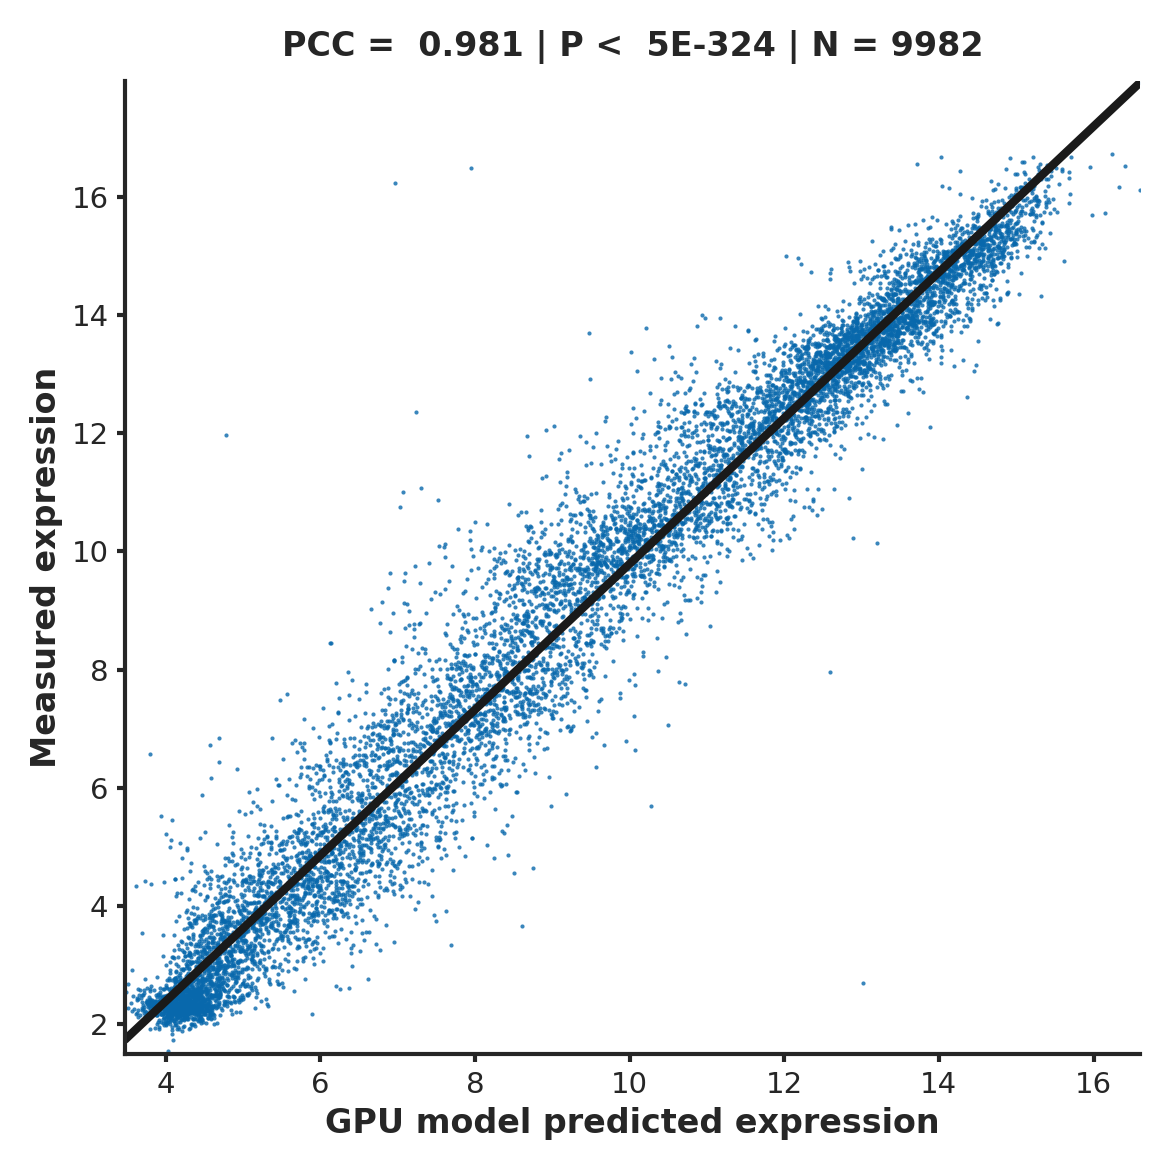

In [132]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [133]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Random_test_gpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,NNNNNNNNNNTGCATTTTTTTCACAAGAGCACTTGAAGGGCGCCTA...,13.708592,12.833848
1,NNNTGCATTTTTTTCACACATATACTTGGGTGACTTAGATATTTGC...,2.553335,4.194172
2,NTGCATTTTTTTCACACATCTGGATTGTCTGGTGTGCTGGTATCTT...,13.369969,12.619181
3,NTGCATTTTTTTCACACCACCGTGGGGATTCGCAGCTATGTGCATA...,3.328683,4.926212
4,NNTGCATTTTTTTCACACCATGGATTTAAGAATTAATCACCGGACA...,10.466688,10.415804
...,...,...,...
9977,NNTGCATTTTTTTCACTCTTTCACGTGGGGCCTGCGGGGTATCGGT...,14.962475,14.932936
9978,NNNNNNNNNNNNTGCATTTTTTTCACTGATGTGGTGCGCGTAATTT...,11.999880,12.140656
9979,TGCATTTTTTTCACTTCCAGTAATATGCGAAAGGGTGATGTGAACT...,4.541188,6.351810
9980,NNNNNNNNNNNNNNTGCATTTTTTTCACTTCGCACTCCACTTCTCG...,7.456650,8.576921


In [251]:

! ls ../../../data/test_data

all_gini_trajectories
combined_validation_experiments_data_with_annotations.txt
HQ_testdata.txt
Native_testdata.csv
Random_testdata.txt
README.md
singleBaseChanges_validation_experiments_data_with_annotations.txt


# Native Test Data (corresponding to Fig. 1c)


### Load native test data (corresponding to Fig. 1c)

#####  ‘Native Test Data’ definition: 
The test data corresponding to Figure 1c. This test dataset corresponds to a set of native yeast promoter sequences from the S288C reference genomes measured in the complex medium. As above, they are measured in an experiment separate from the large training data generation experiment. 



In [134]:
native_df = pd.read_csv('../../../data/test_data/Native_testdata.csv', index_col = 0 )

### Generate expression predictions using the GPU only model

In [141]:
sequences = list(native_df.seq110.values) ### sequence
expressions= list(native_df.meanEL) ### measured expression


### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py

### Compute and Print the Pearson's r between Measured and Predicted expression

- It can be noted that the performance TPU model is better than the GPU model on the native test data

In [142]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Native test data is', format(pcc, '0.3f'))


The Pearson's r for the Native test data is 0.948


### Plot the results 

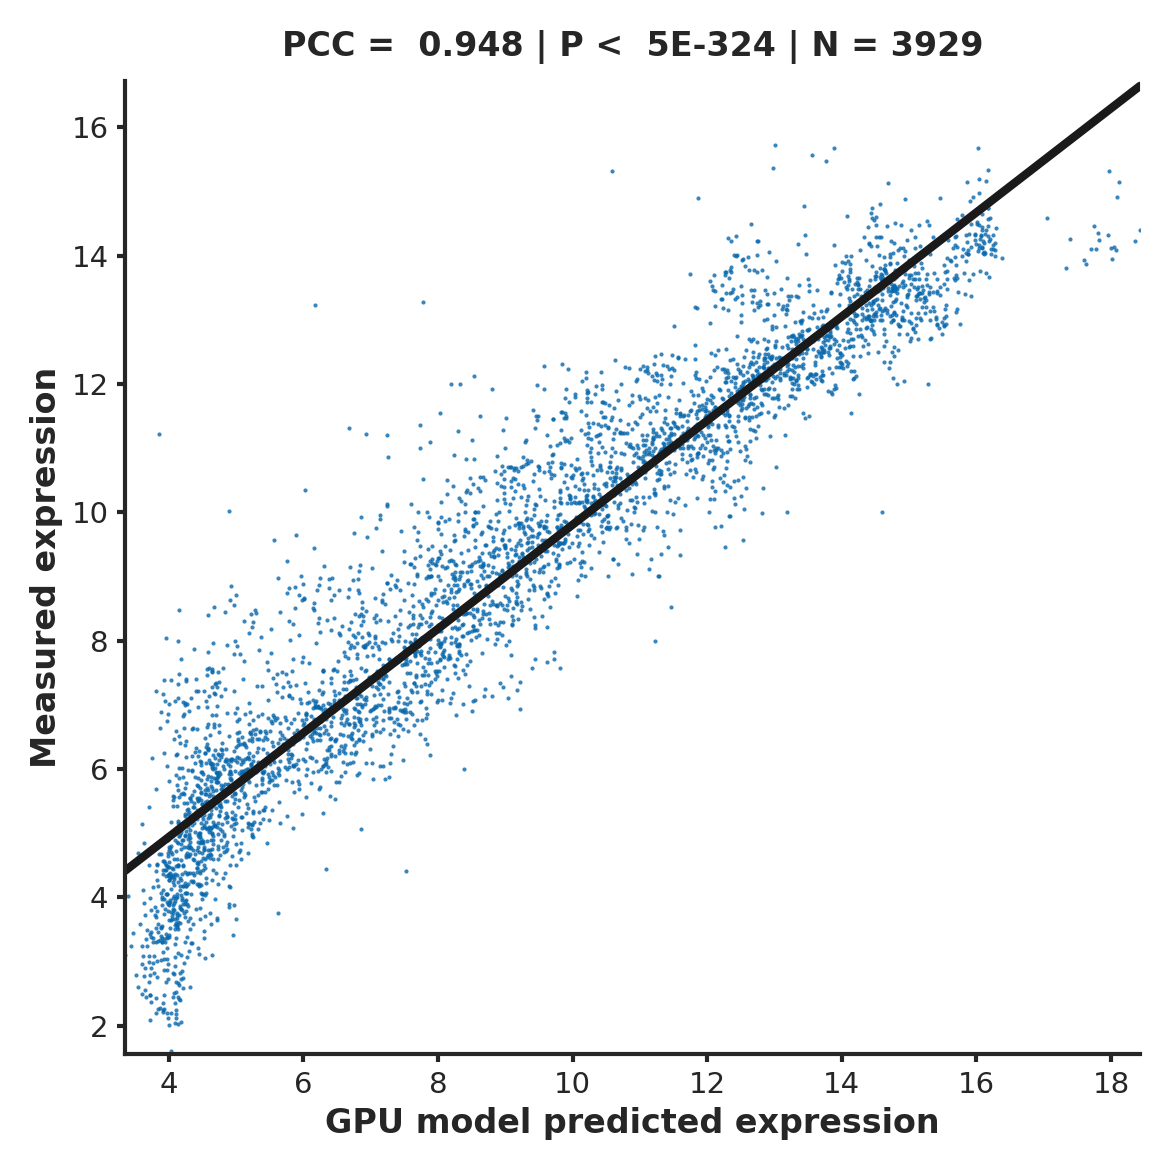

In [143]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance_native"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [144]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Native_test_gpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816,14.446554
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919,14.376523
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758,14.644972
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120,12.361234
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583,14.779208
...,...,...,...
3924,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.344921,6.029851
3925,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,6.589246,5.433020
3926,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.740563,5.998018
3927,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCCTTATTCT...,7.421802,5.548253


# Reconstructing the random mutational drift validation experiment prediction result (Extended Data Fig. 2j) corresponding to Figure  2a-c using the GPU model's predictions (instead of the TPU model's predictions as shown in the paper)
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have further questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [95]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium
    fig_df = snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_YPD')] #(snp_df.randMut) &

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/Drift_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/Drift_testdata.csv' , index_col =0)

### Generate expression predictions using the GPU only model

In [96]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL.mut'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


### Compute and Print the Pearson's r between Measured and Predicted expression

In [82]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random Drift test data (corresponding to the section for Fig 2a-c) is', format(pcc, '0.3f'))


The Pearson's r for the Random Drift test data (corresponding to the section for Fig 2a-c) is 0.973


### Plot the results 

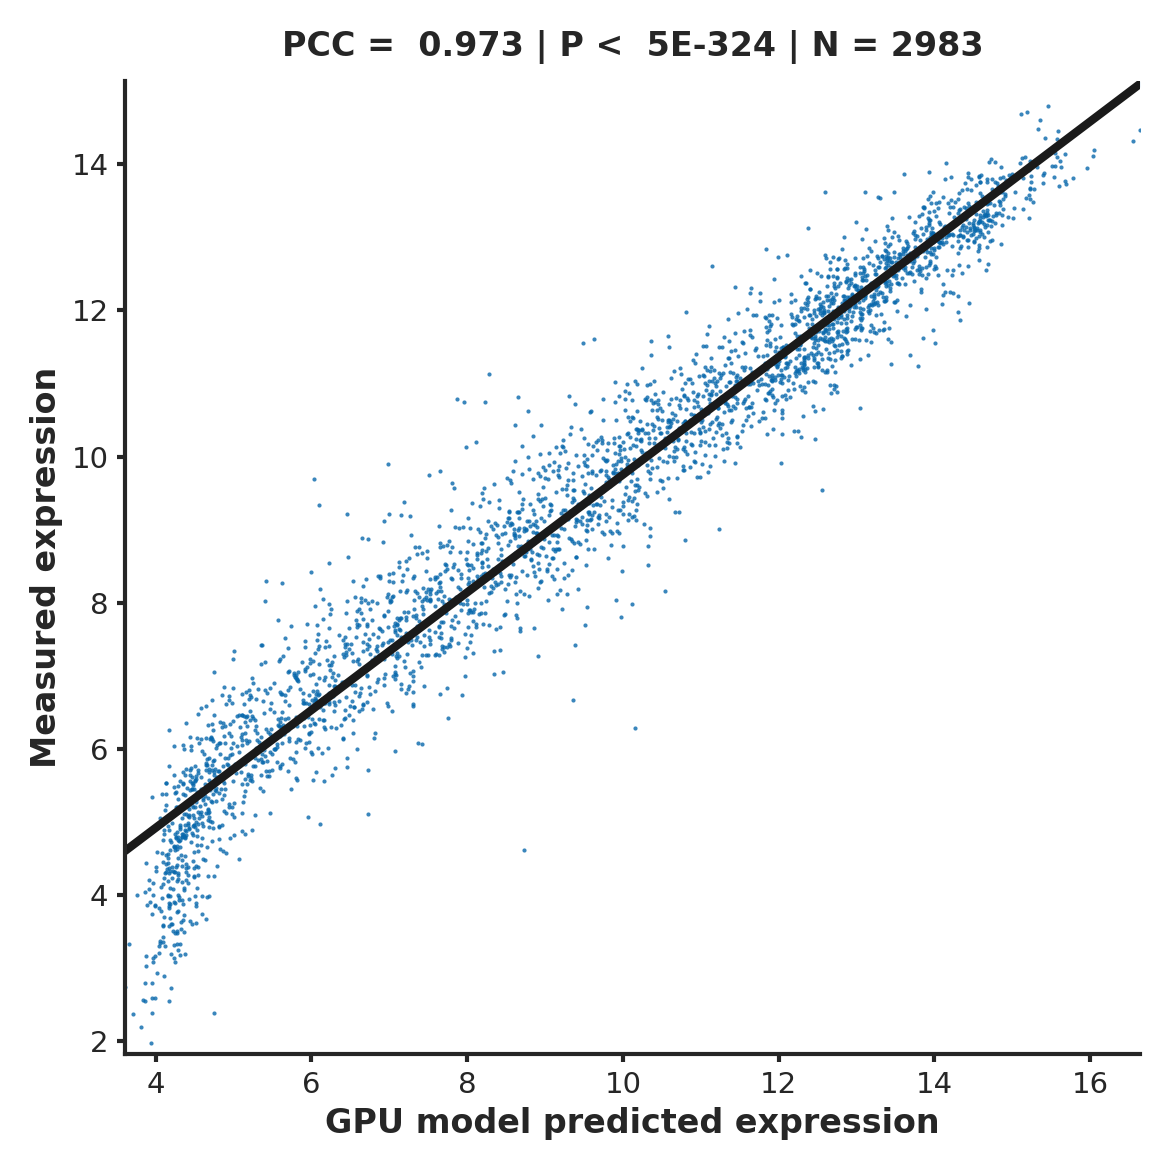

In [86]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance_drift"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [87]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Drift_test_gpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACGGCGC...,11.278011,12.510292
1,TGCATTTTTTTCACATCCTTTAAATTCGGTGGGGACGCGTCGGCGC...,11.725461,13.287679
2,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACCGCGC...,11.725053,12.604548
3,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGAGGACAGTC...,9.008385,11.232876
4,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGACGACAGTC...,10.695459,12.444765
...,...,...,...
2978,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTATGAATATCGTAAC...,12.134682,13.076027
2979,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTACGAGTATCGTAAC...,13.562228,14.613718
2980,TGCATTTTTTTCACATCGGAACGTTAACATCAATCCGGTCACCACG...,10.788450,10.286640
2981,TGCATTTTTTTCACATCGGAACGTTAATATCCATCCGGTCACCACG...,12.423164,11.934329


# Reconstructing the SSWM validation experiment prediction result (Extended Data Fig. 2l) corresponding to Figure  2e-g using the GPU model's predictions (instead of the TPU model's predictions as shown in the paper)
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [89]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/SSWM_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/SSWM_testdata.csv' , index_col =0)

### Generate expression predictions using the GPU only model


In [91]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

### Compute and Print the Pearson's r between Measured and Predicted expression

In [92]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the SSWM test data (corresponding to the section for Fig 2e-f) is', format(pcc, '0.3f'))


The Pearson's r for the SSWM test data (corresponding to the section for Fig 2e-f) is 0.980


### Plot the results 

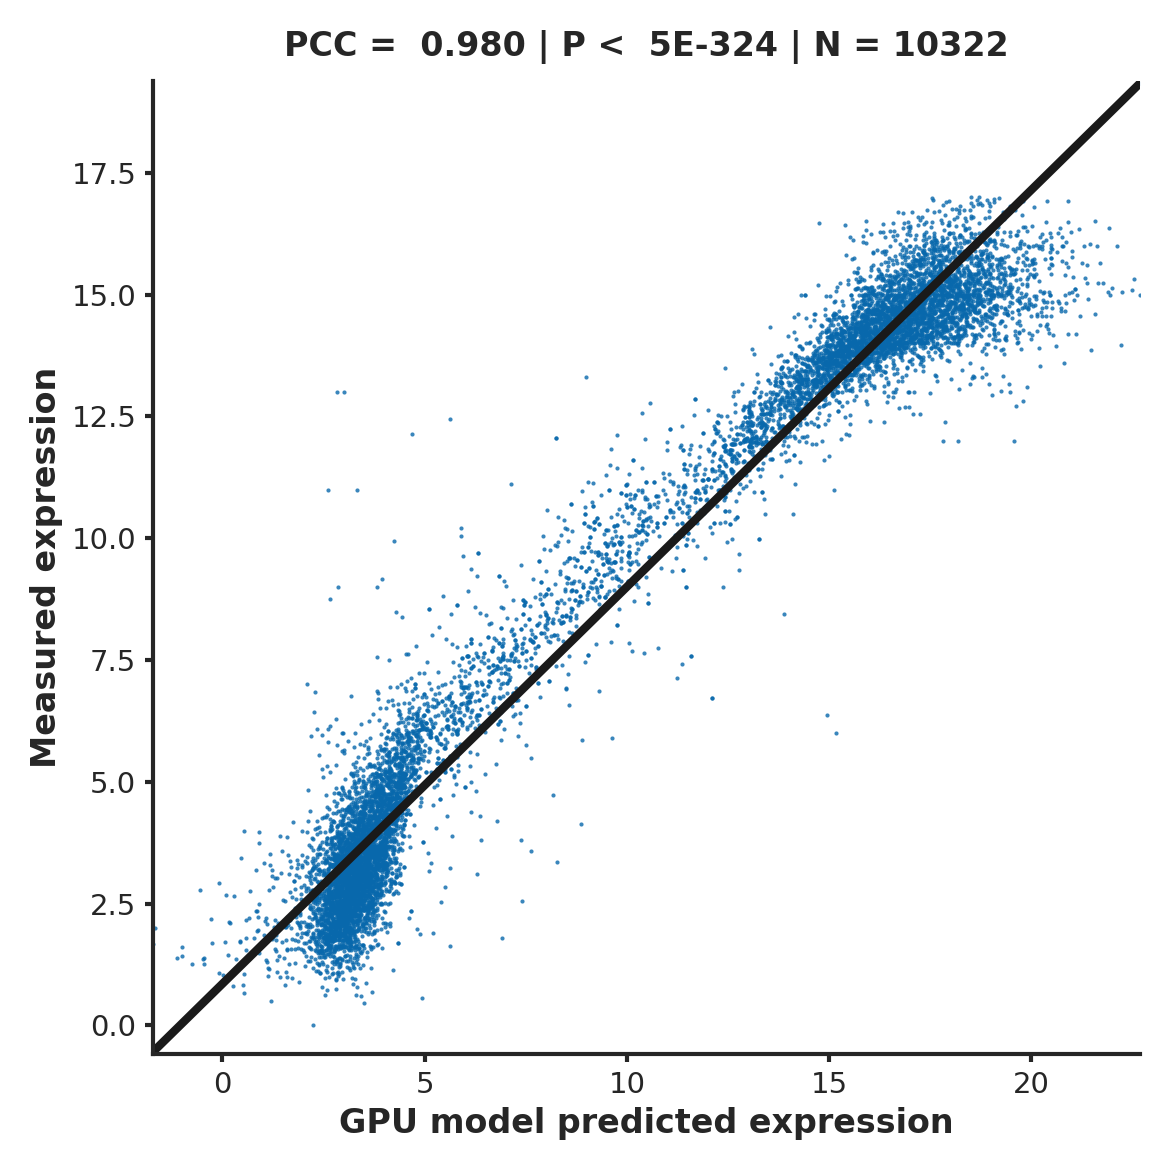

In [93]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance_sswm"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [94]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/SSWM_test_gpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.726824
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.726824
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,14.000000,15.528961
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.000000,17.193554
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.783623,16.947123
...,...,...,...
10317,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,15.644227,20.848137
10318,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.604007,19.383139
10319,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.581721,18.274517
10320,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,13.727267,17.774937


# Prediction results corresponding to Figure 1d (the Genetic Algorithm panel ) using the GPU model's predictions vs the measured expression 


##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [136]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium


    fig_df = full_df[(full_df.expt=='NBT_S288CdU_YPD') &   
                              (full_df.designedCond=='Glu')&  
                              (full_df.designed==1)]

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/ga_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/ga_testdata.csv' , index_col =0)

### Generate expression predictions using the GPU only model

In [137]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

### Compute and Print the Pearson's r between Measured and Predicted expression

In [138]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Genetic Algorithm test data (corresponding to the section for Fig 1d) is', format(pcc, '0.3f'))


The Pearson's r for the Genetic Algorithm test data(corresponding to the section for Fig 1d) is 0.989


### Plot the results 

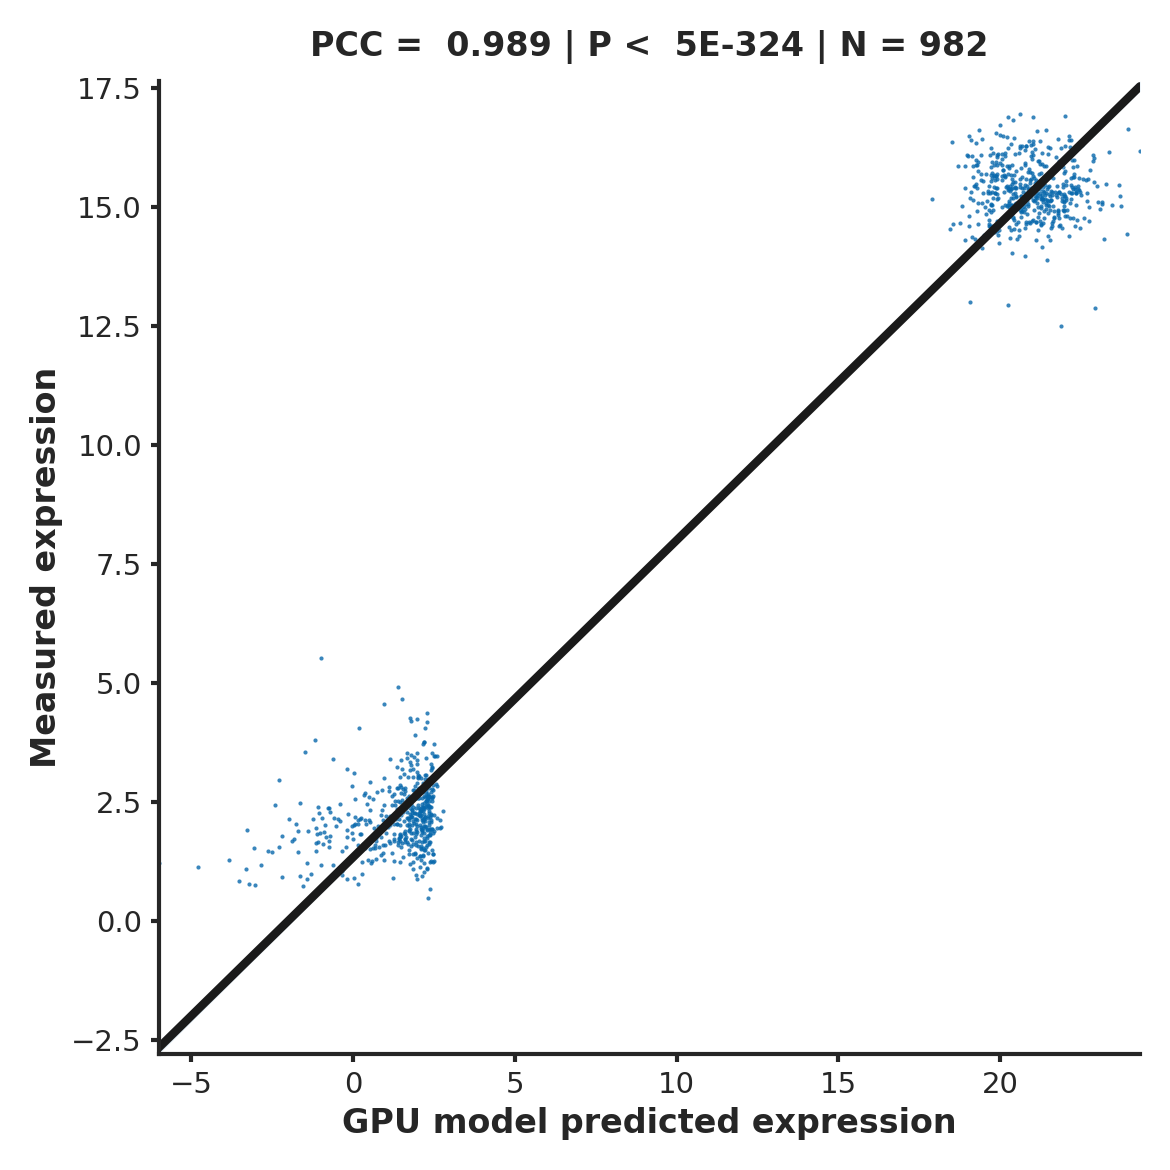

In [98]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance_ga"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [99]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/ga_test_gpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAGGCTATTTGATATGTTAAAAGAAGG...,1.244706,1.438940
1,TGCATTTTTTTCACATCAAACAATCTCTTGATGTGTCAGAAATAAG...,0.980188,0.280351
2,TGCATTTTTTTCACATCAAACAATGGGTTGTCATCTTCTAAGATAG...,2.764484,2.446017
3,TGCATTTTTTTCACATCAAACTATTGTTAGATGTCAAATGAACTAC...,1.414264,2.474411
4,TGCATTTTTTTCACATCAAACTCTATCATTTCTGCAGAGGTTGCAA...,2.241734,1.981817
...,...,...,...
977,TGCATTTTTTTCACATCTTTTGATATAACCTGGTCGAATATACTAT...,3.232783,2.447499
978,TGCATTTTTTTCACATCTTTTGCAACTATTTCACCAAATGGTATCC...,3.432195,2.260328
979,TGCATTTTTTTCACATCTTTTGTAATAGTAGATGTCAATGGGATAG...,3.305018,2.419306
980,TGCATTTTTTTCACATCTTTTTCCGGGTGACGGCGCGACTTTGTGC...,15.260873,21.606190


# Gini trajectories

### Save results

In [19]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]


model_name = 'GPU model'

for i in [-1,1,-2,2,0]: 
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


    results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})

    results_df.to_csv('../../../results_summary/'+file_list[i].split('/')[-1]+'_gpu_model.csv')

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

### Plot Results

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

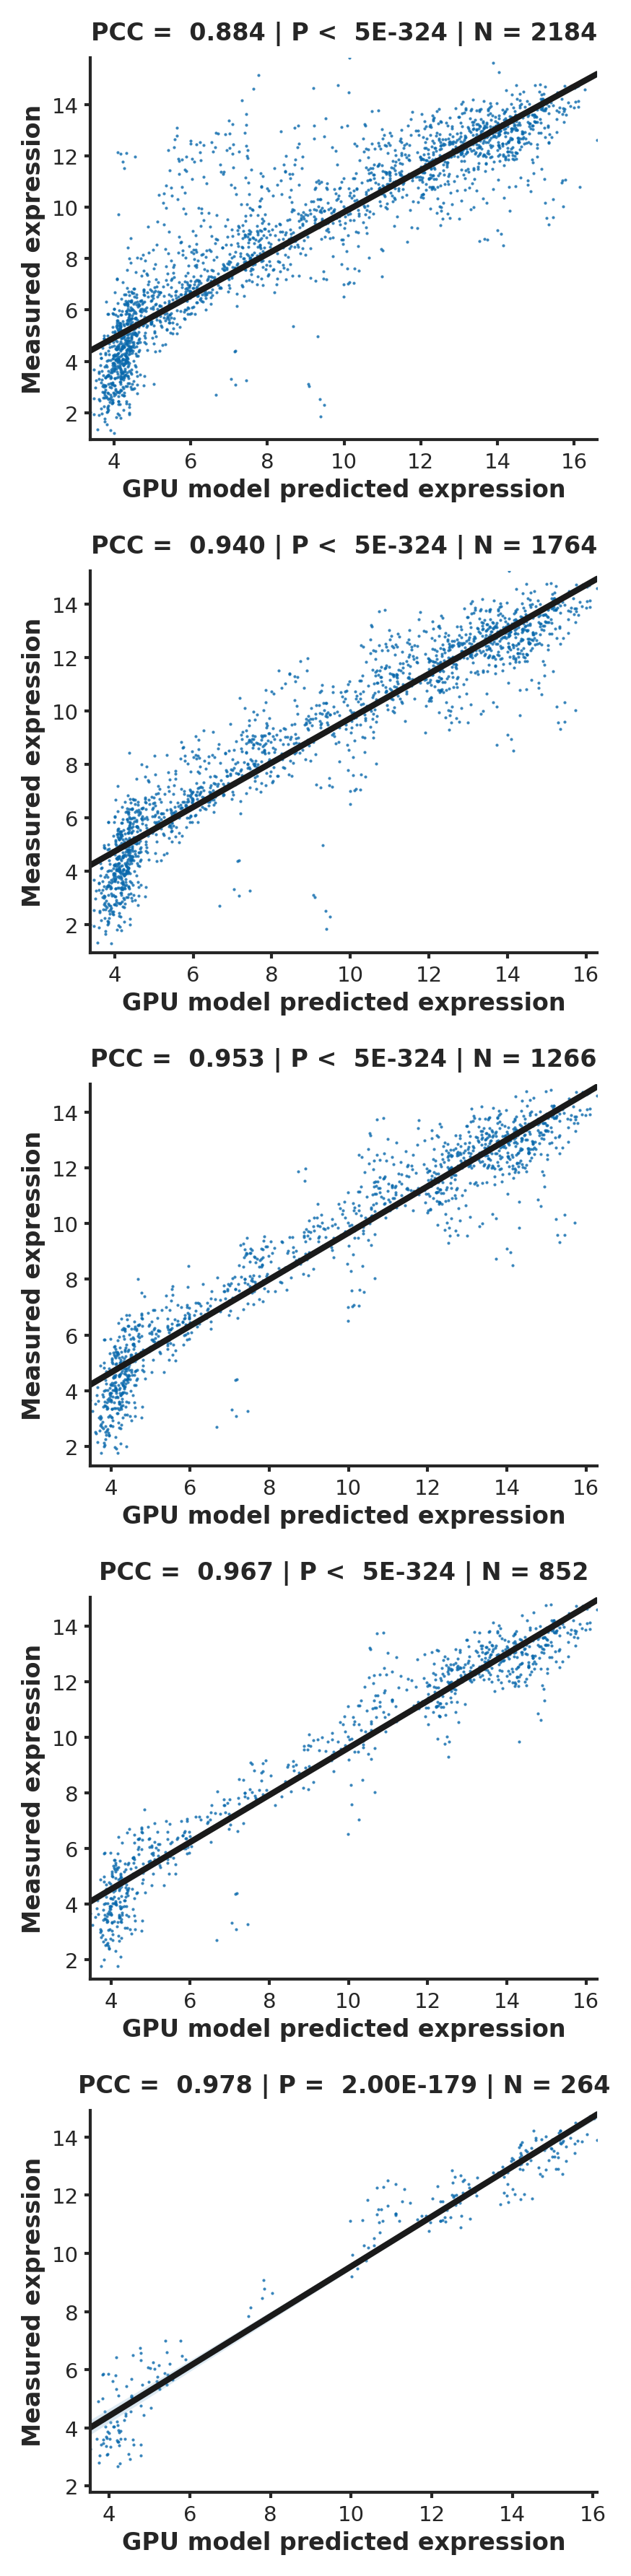

In [23]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]


model_name = 'GPU model'

fig_file = model_name+" prediction_performance_gini"

fig=plt.figure(figsize=(12/4,12) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


index = 1
for i in [-1,1,-2,2,0]: 
    plt.subplot(5, 1, index)
    index = index+1
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )

    x = list(predicted_expressions)
    y = expressions

    
    
    
    
    
    r = scipy.stats.pearsonr(x ,y )
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':2} ,
                color= '#0868ac', robust = 1 )



    ax = plt.gca()
    #ax.get_legend().remove()


    ax.set_xlabel(model_name + " predicted expression")
    ax.set_ylabel("Measured expression")
    if (r[1] ==0.0) :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
    else :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    #plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-8,xmax=8)
    #ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

# Reconstructing the random mutational drift validation experiment prediction result for expression difference corresponding to Figure  2a-c using the GPU model's predictions (instead of the TPU model's predictions as shown in the paper)
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have further questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [4]:
if 1 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    expt = 'NBT_S288CdU_YPD'
    ###Extract sequences corresponding to random drift in the complex medium
    fig_df = snp_df.loc[(snp_df.rand) & (snp_df.expt==expt)] #(snp_df.randMut) &

 
    #full_df[(full_df.origID=='rand1')]

### Generate expression predictions using the GPU only model

In [5]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL.mut'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

In [6]:
df = copy.deepcopy(fig_df)
df['edvPred_gpu.mut'] = predicted_expressions


edvPred_delta = []
measured_delta = []

ED = []

baseSeq_list = [ i for i in np.unique(df.baseSeq)]

baseSeq110_list = []
baseSeq_meanEL_list = []
baseSeq_edvPred_tpu_list = []

for baseSeq  in baseSeq_list :
    baseSeq_df = df[df.baseSeq==baseSeq]
    ### Get baseSeq prediction and measurement from df
    baseSeq110_list = baseSeq110_list + [full_df[(full_df.origID==baseSeq) & (full_df.expt==expt)].seq110.values[0]]
    baseSeq_meanEL_list = baseSeq_meanEL_list + [full_df[(full_df.origID==baseSeq) & (full_df.expt==expt)]['meanEL'].values[0]]
    baseSeq_edvPred_tpu_list = baseSeq_edvPred_tpu_list + [full_df[(full_df.origID==baseSeq) & (full_df.expt==expt)]['edvPred'].values[0]]

baseSeq_edvPred_gpu_list =  list(np.asarray(getPredictions(baseSeq110_list , sess , graph, X, X_rc, Y, model_cost, model_output) ))



for i,baseSeq  in enumerate(baseSeq_list) :
    baseSeq_df = df[df.baseSeq==baseSeq]

    measured_delta = measured_delta + list(baseSeq_df['meanEL.mut'].values - 
                                                baseSeq_df['meanEL.base'].values[0])
    
    edvPred_delta =edvPred_delta + list(baseSeq_df['edvPred_gpu.mut'].values - 
                                             baseSeq_edvPred_gpu_list[i])

    ED = ED + list(baseSeq_df.ED.values)

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

### Compute and Print the Pearson's r between Measured and Predicted expression

In [7]:

pcc = scipy.stats.pearsonr(measured_delta,edvPred_delta)[0]
print(f'The Pearson\'s r for the Random Drift test data (corresponding to the section for Fig 2a-c) is (expression difference)', format(pcc, '0.3f'))


The Pearson's r for the Random Drift test data (corresponding to the section for Fig 2a-c) is (expression difference) 0.869


### Plot the results 

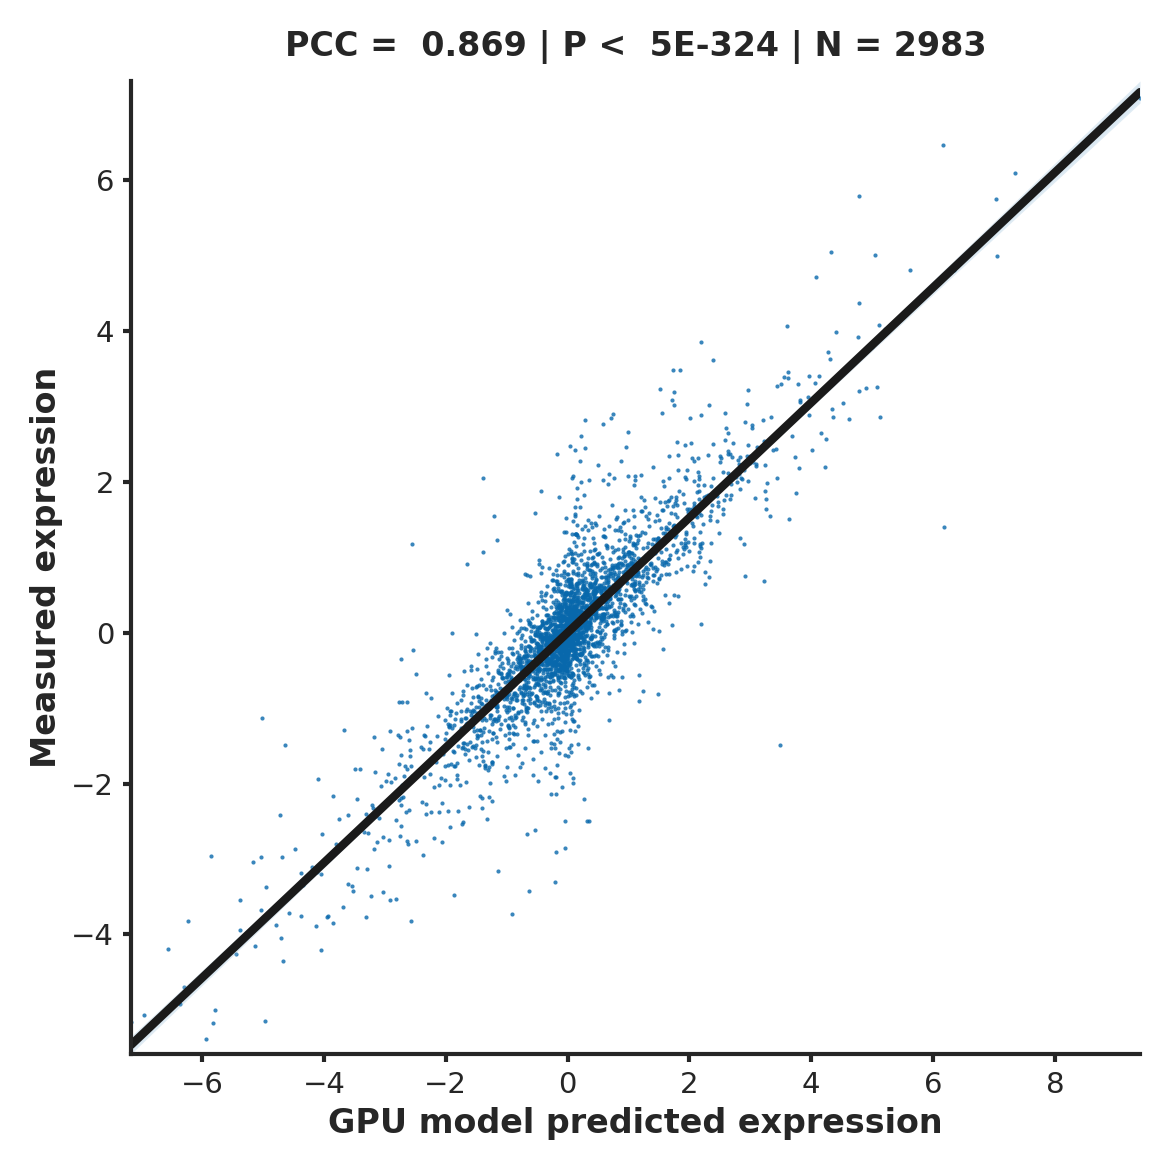

In [8]:
model_name = 'GPU model'

fig_file = model_name+" prediction_performance_drift_delta"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(edvPred_delta)
y = measured_delta

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [192]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Drift_test_gpu_model_delta.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACGGCGC...,11.278011,12.510294
1,TGCATTTTTTTCACATCCTTTAAATTCGGTGGGGACGCGTCGGCGC...,11.725461,13.287676
2,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACCGCGC...,11.725053,12.604546
3,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGAGGACAGTC...,9.008385,11.232876
4,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGACGACAGTC...,10.695459,12.444769
5,TGCATTTTTTTCACATCTTTTCCGTGCGACGGCCTAGAGGACAGTC...,11.749696,13.355394
6,TGCATTTTTTTCACATCATATTTTAGGTATTATCGCGTTGGTCGTA...,11.576229,12.597545
7,TGCATTTTTTTCACATCATGTTTTAGGTATAATCGCGTTGGTCGTA...,10.609223,11.056576
8,TGCATTTTTTTCACATCATGTTTTAGGTATAATCGCGTTGGTCGTA...,10.310665,10.056723
9,TGCATTTTTTTCACATCTTTAGTTTTTCCTATGATGTGCGGGGCTC...,10.324101,10.284050


# Reconstructing the SSWM validation experiment prediction result for expression difference corresponding to Figure  2e-g using the GPU model's predictions (instead of the TPU model's predictions as shown in the paper)
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [221]:
if 1 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'



/ahg/regevdata/users/edv/software/anaconda3/envs/scIB-python/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Generate expression predictions using the GPU only model


In [230]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )

fig_df['edvPred'] = predicted_expressions

/ahg/regevdata/users/edv/software/anaconda3/envs/scIB-python/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



100%|██████████| 441/441 [00:16<00:00, 27.22it/s]

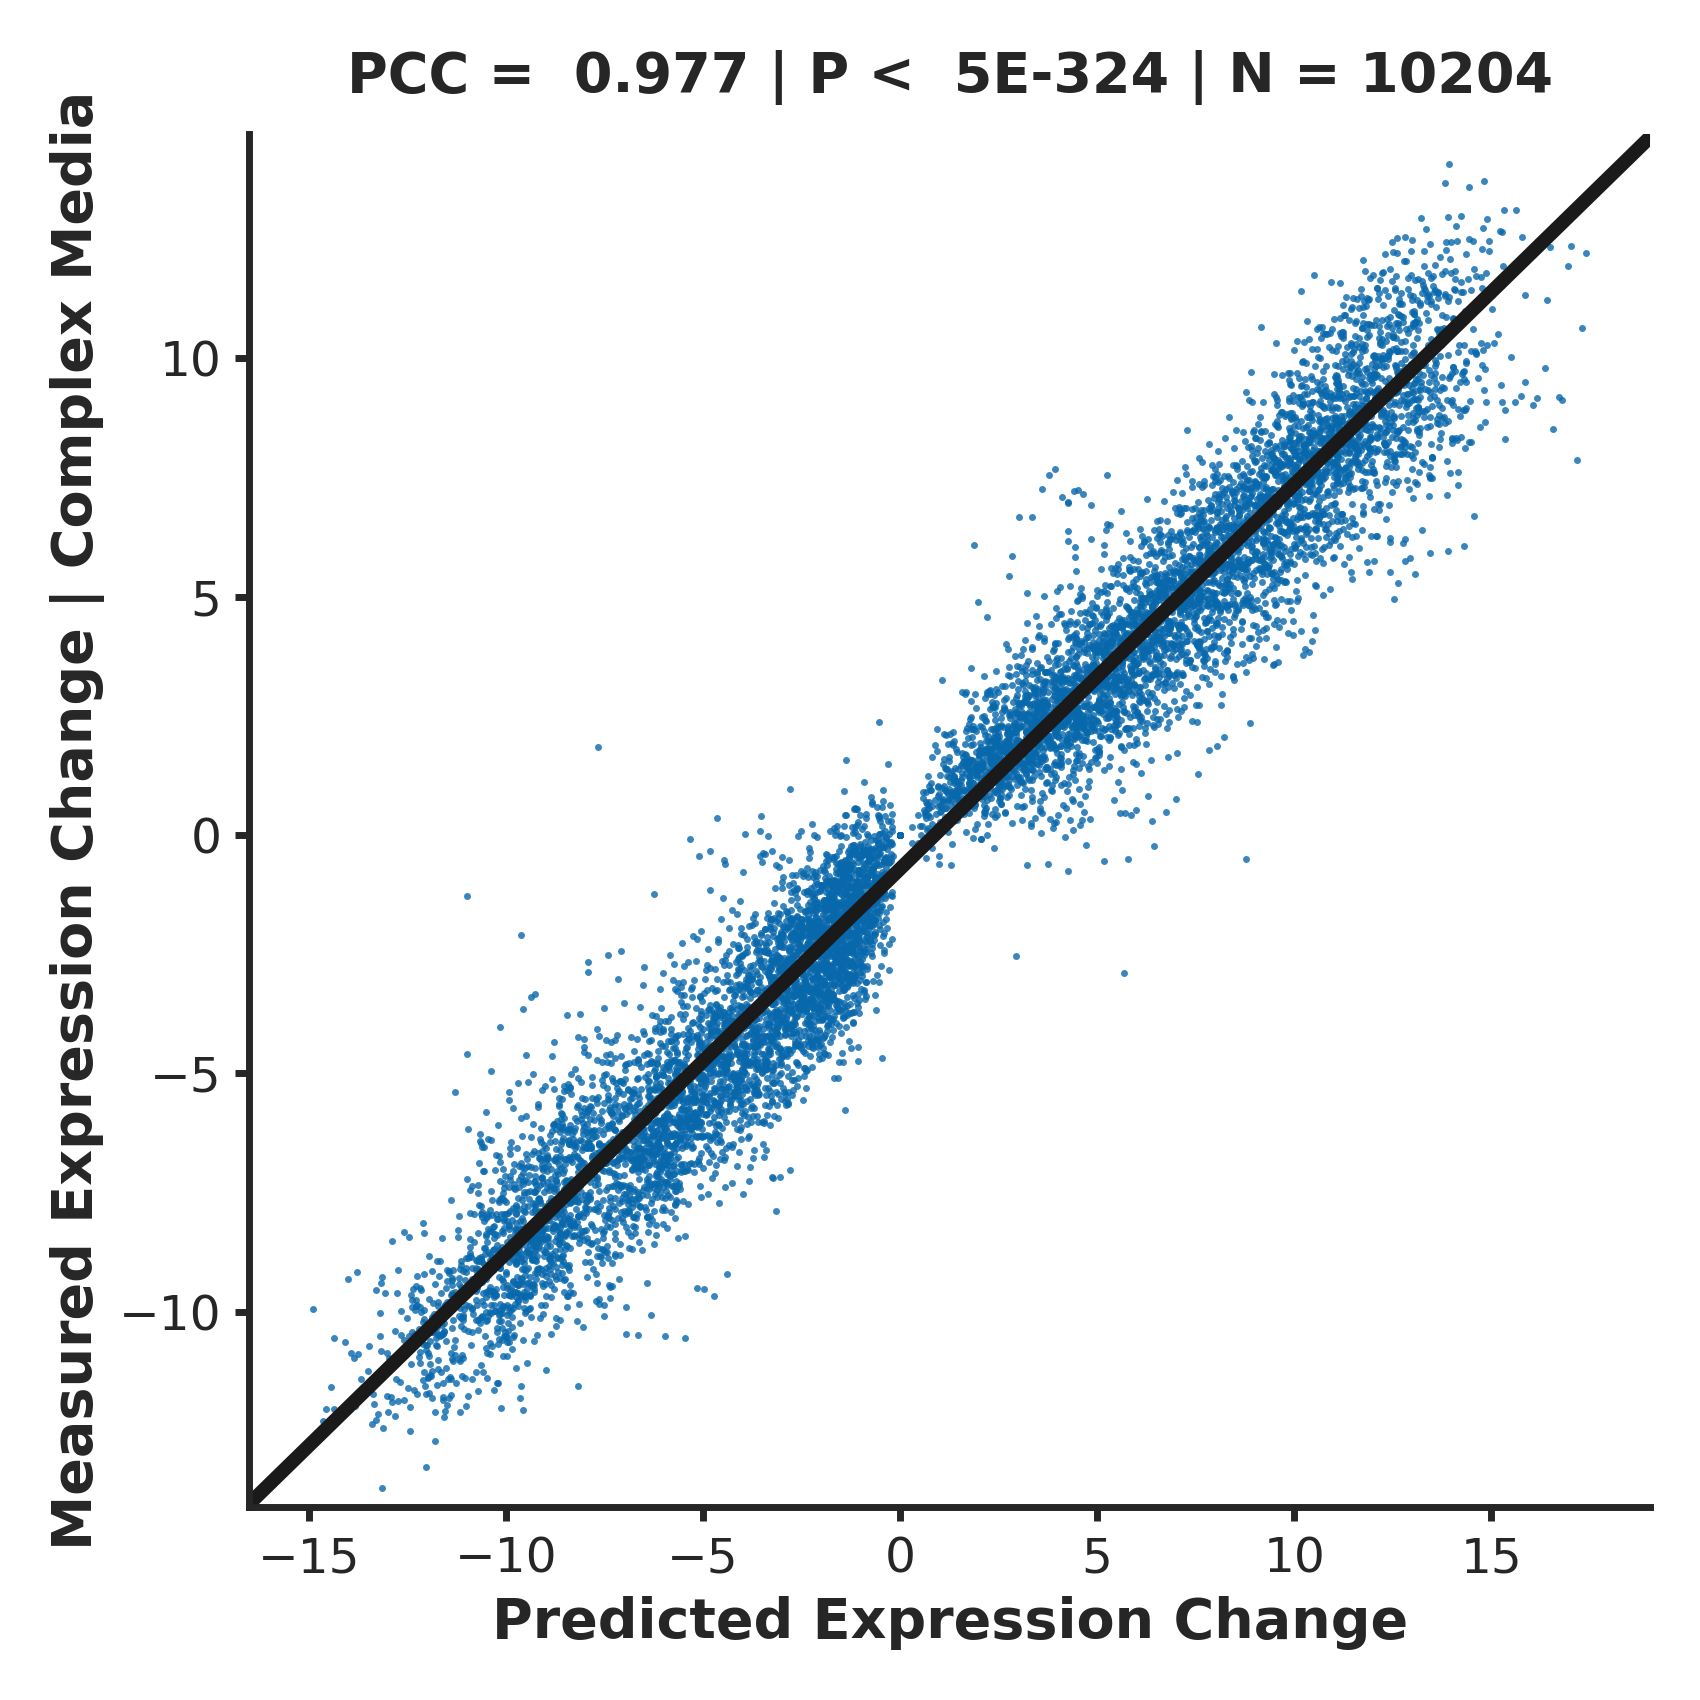

In [241]:
#len(baseSeq_list) is 441

edvPred_delta = []
measured_delta = []

for trajDir in [ 'max' , 'min'] : 
    df_trajDir = fig_df[fig_df.trajDir== trajDir]

    baseSeq_list = [ i for i in np.unique(fig_df.baseSeq)]
    for baseSeq  in tqdm(baseSeq_list) :
        baseSeq_df = df_trajDir[df_trajDir.baseSeq==baseSeq]
        ED_list = baseSeq_df.ED.sort_values().values
        for ED in ED_list :
            if 0 in ED_list:
                measured_delta = measured_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].meanEL.values - baseSeq_df[baseSeq_df.ED==0].meanEL.values)] 
                edvPred_delta =edvPred_delta + [np.float(baseSeq_df[baseSeq_df.ED==ED].edvPred.values - baseSeq_df[baseSeq_df.ED==0].edvPred.values)] 


                
                
fig_file = 'trajectory_validation_glu_scatter_delta'
fig=plt.figure( figsize =(3.5 , 3.5), dpi= 500, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


x = edvPred_delta
y = measured_delta
r = scipy.stats.pearsonr(edvPred_delta ,measured_delta )



### Plotting
ax = sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac' )



### Axes adjustments and Titles

ax = plt.gca()


ax.set_xlabel("Predicted Expression Change"  )
ax.set_ylabel("Measured Expression Change | Complex Media") 
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(edvPred_delta)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(edvPred_delta)}"  )



#plt.tight_layout()
plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=3.1)

#ax.set_ylim(ymin=-3.25,ymax=3.25)








plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()








### Compute and Print the Pearson's r between Measured and Predicted expression

In [245]:

pcc = scipy.stats.pearsonr(x,y)[0]
print(f'The Pearson\'s r for the SSWM test data (corresponding to the section for Fig 2e-f) for expression difference is', format(pcc, '0.3f'))


The Pearson's r for the SSWM test data (corresponding to the section for Fig 2e-f) for expression difference is 0.977


### Save the results to a file for convenient generation of summary plots

In [94]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/SSWM_test_gpu_model_delta.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.726824
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.726824
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,14.000000,15.528961
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.000000,17.193554
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.783623,16.947123
...,...,...,...
10317,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,15.644227,20.848137
10318,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.604007,19.383139
10319,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.581721,18.274517
10320,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,13.727267,17.774937


### Scatterplots for SSWM trajectories at each mutational step | Complex Media

In [5]:
### Extract the relevant data from combined file
full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')

fig_df = full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')] 

### Generate expression predictions using the GPU only model


In [6]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = np.asarray(getPredictions(sequences , sess , graph, X, X_rc, Y, model_cost, model_output) )

fig_df['edvPred'] = predicted_expressions

/ahg/regevdata/users/edv/software/anaconda3/envs/scIB-python/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


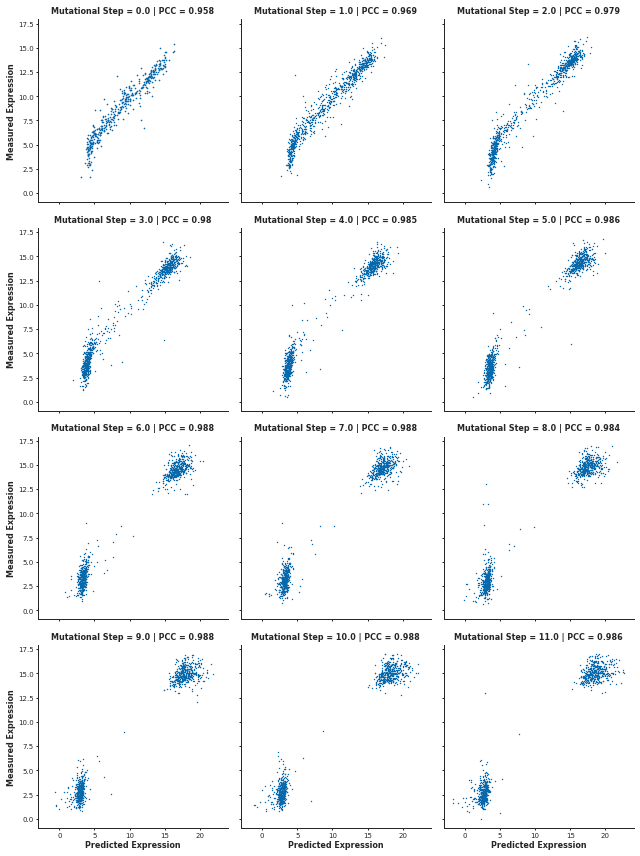

In [8]:
extracted_df = copy.deepcopy(fig_df)
extracted_df['Mutational Step'] = extracted_df['ED']  
extracted_df['Predicted Expression'] = extracted_df['edvPred']  
extracted_df['Measured Expression'] = extracted_df['meanEL']  
### Create title 
col_order = []
for i in np.sort(np.unique(extracted_df['ED'])) : 
    step_df = extracted_df[extracted_df['Mutational Step'] == i]
    pcc = scipy.stats.pearsonr(step_df.meanEL,step_df.edvPred)[0]
    colname = str(i) +' | PCC = ' + str(round( pcc, 3))
    extracted_df.loc[extracted_df['Mutational Step'] == i , 'Mutational Step'] =   colname
    col_order = col_order + [colname]
    
from matplotlib.backends.backend_pdf import PdfPages

g = sns.FacetGrid(extracted_df , col = 'Mutational Step' ,  col_wrap=3 , 
                  col_order = col_order )
g.map(sns.scatterplot,  "Predicted Expression" , "Measured Expression" ,
     s= 2 , linewidth = 0 , rasterized = 1 , color  = '#0868ac')



figfile = 'SSWM_stepwise_scatterplot_complex_media_gpu'

g.savefig(figfile + ".pdf")
g.savefig(figfile + ".png")
plt.show()

### How to generate predictions for your own sequences in this notebook


In [7]:
newseq =['AAAAAGCCAAATTAGACATGTATTTAATTATAAATAGATTAGTAAAACATATATTCTAAATTAAAACAGCACTTTAACCG']
newseq = population_add_flank(newseq)
np.asarray(getPredictions(newseq , sess , graph, X, X_rc, Y, model_cost, model_output) )

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.

array([12.14097691])